R Code pulled from https://www.statmethods.net/advgraphs/ggplot2.html

In [2]:
# ggplot2 examples
library(ggplot2) 

NameError: name 'library' is not defined

In [ ]:
# create factors with value labels 
mtcars$gear <- factor(mtcars$gear,levels=c(3,4,5),
  	labels=c("3gears","4gears","5gears")) 
mtcars$am <- factor(mtcars$am,levels=c(0,1),
  	labels=c("Automatic","Manual")) 
mtcars$cyl <- factor(mtcars$cyl,levels=c(4,6,8),
   labels=c("4cyl","6cyl","8cyl")) 

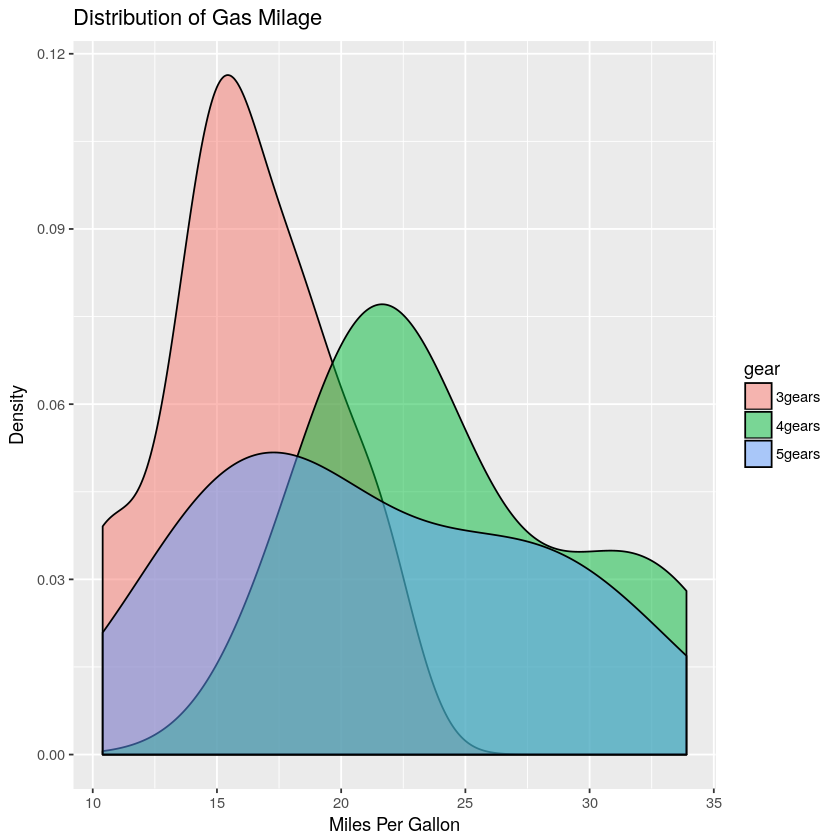

In [ ]:
# Kernel density plots for mpg
# grouped by number of gears (indicated by color)
qplot(mpg, data=mtcars, geom="density", fill=gear, alpha=I(.5), 
   main="Distribution of Gas Milage", xlab="Miles Per Gallon", 
   ylab="Density")

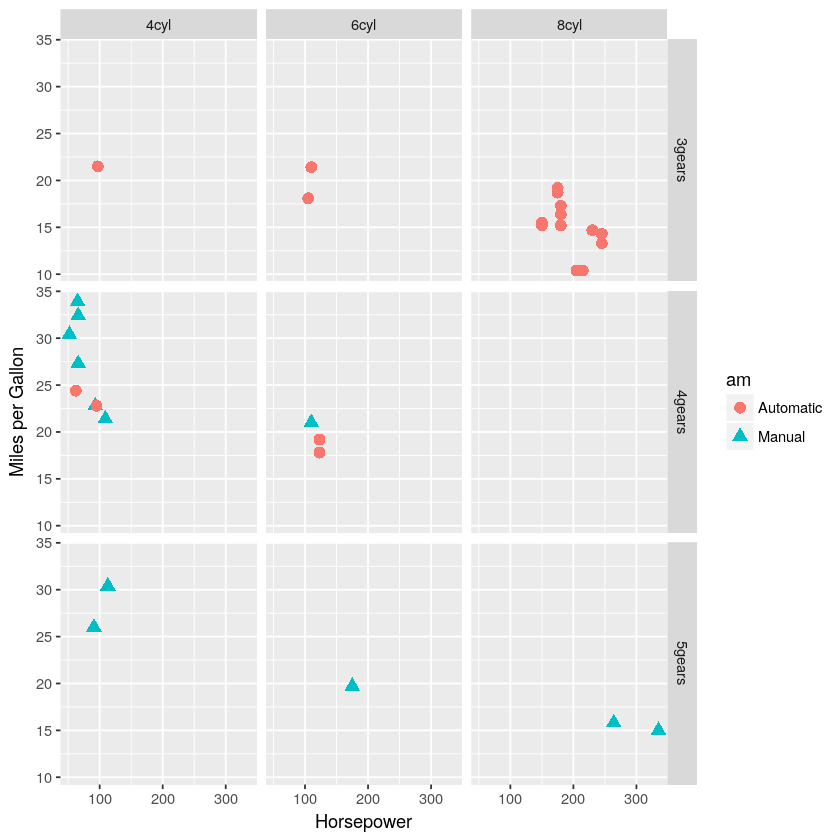

In [ ]:
# Scatterplot of mpg vs. hp for each combination of gears and cylinders
# in each facet, transmittion type is represented by shape and color
qplot(hp, mpg, data=mtcars, shape=am, color=am, 
   facets=gear~cyl, size=I(3),
   xlab="Horsepower", ylab="Miles per Gallon") 

Warning message:
“Ignoring unknown parameters: method, formula”

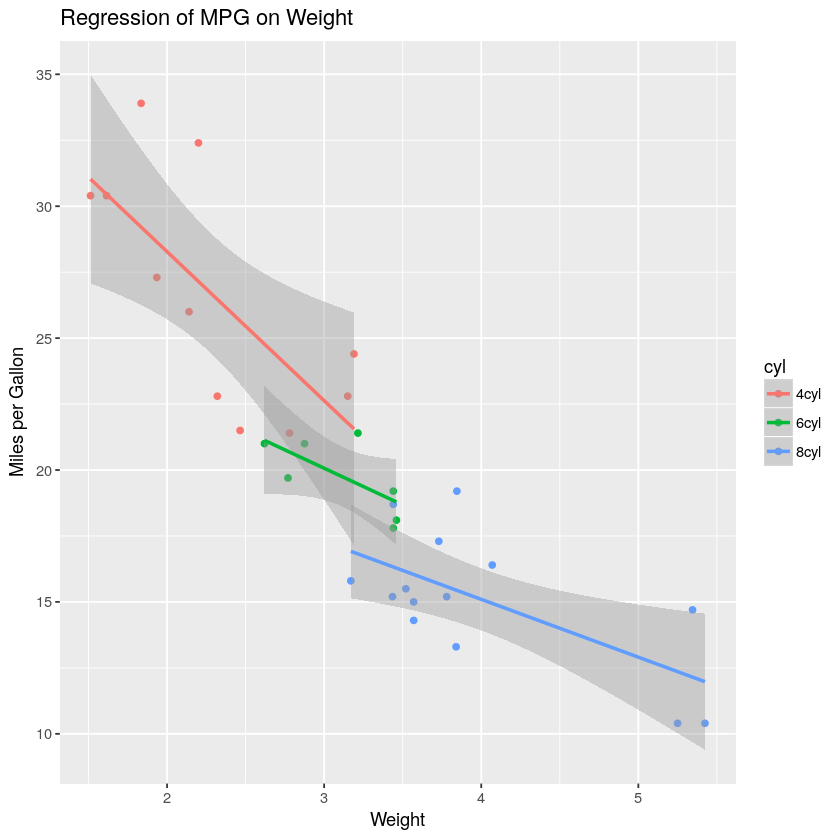

In [ ]:
# Separate regressions of mpg on weight for each number of cylinders
qplot(wt, mpg, data=mtcars, geom=c("point", "smooth"), 
   method="lm", formula=y~x, color=cyl, 
   main="Regression of MPG on Weight", 
   xlab="Weight", ylab="Miles per Gallon")

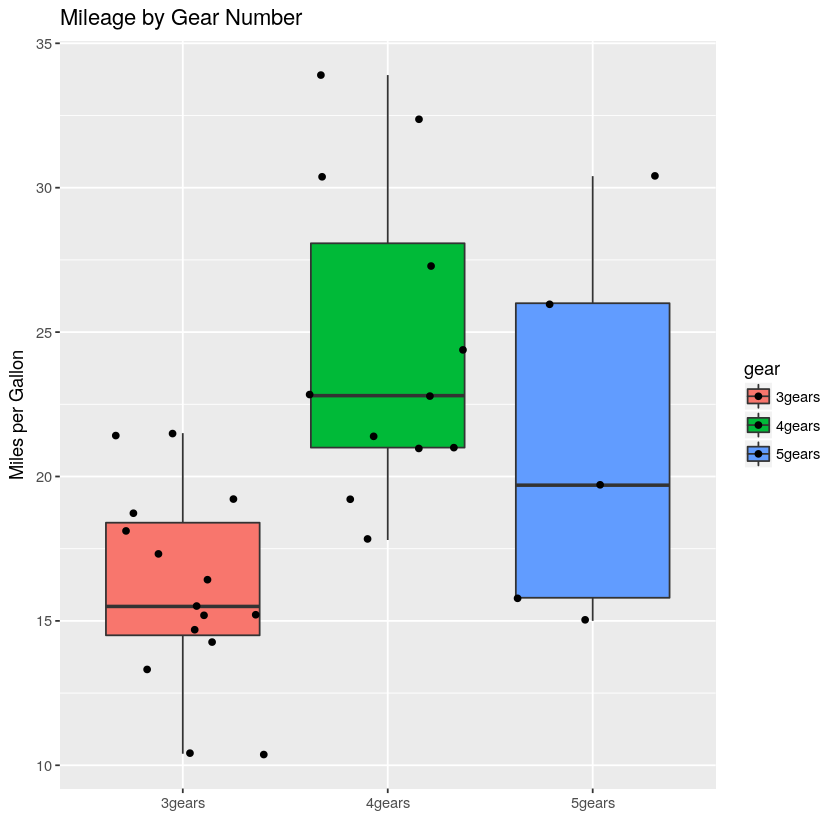

In [ ]:
# Boxplots of mpg by number of gears 
# observations (points) are overlayed and jittered
qplot(gear, mpg, data=mtcars, geom=c("boxplot", "jitter"), 
   fill=gear, main="Mileage by Gear Number",
   xlab="", ylab="Miles per Gallon")